In [81]:
import os
from pyspark.sql import SparkSession
# Import the requisite items
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Column as Col
#from pyspark.sql.functions import monotonically_increasing_id

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import missingno as msno
import pandas_profiling

%matplotlib inline
# Customise plots
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 12

# Initialise spark
spark = SparkSession.builder\
                    .appName('Small_movie')\
                    .master('local[*]')\
                    .getOrCreate()

# Load data 
links = spark.read\
             .csv('../data/links.csv',\
                  header=True,\
                  inferSchema=True)
links.createOrReplaceTempView('links')

movies = spark.read\
             .csv('../data/movies.csv',\
                  header=True,\
                  inferSchema=True)
movies.createOrReplaceTempView('movies')

ratings = spark.read\
             .csv('../data/ratings.csv',\
                  header=True,\
                  inferSchema=True)
ratings.createOrReplaceTempView('ratings')

tags = spark.read\
             .csv('../data/tags.csv',\
                  header=True,\
                  inferSchema=True)
tags.createOrReplaceTempView('tags')



In [70]:
# Movies dataframe analysis
# Find distinct values
for col in movies.columns:
    n_count_distinct = movies.select(col).distinct().count()
    print('{0}: {1}'.format(col, n_count_distinct))

movieId: 9742
title: 9737
genres: 951


In [71]:
# Find duplicate titles
movies.groupBy('title').count().filter('count > 1').show()

# Drop duplicate titles
movies = movies.drop_duplicates(subset=['title'])

+--------------------+-----+
|               title|count|
+--------------------+-----+
|         Eros (2004)|    2|
|Confessions of a ...|    2|
|         Emma (1996)|    2|
|     Saturn 3 (1980)|    2|
|War of the Worlds...|    2|
+--------------------+-----+



In [72]:
movies.show(1, vertical=True)

-RECORD 0-----------------------
 movieId | 112138               
 title   | 22 Jump Street (2... 
 genres  | Action|Comedy|Crime  
only showing top 1 row



In [73]:
ratings.show(1, vertical=True)

-RECORD 0--------------
 userId    | 1         
 movieId   | 1         
 rating    | 4.0       
 timestamp | 964982703 
only showing top 1 row



In [80]:
# Ratings dataframe 
# Find distinct values
for col in ratings.columns:
    n_count_distinct = ratings.select(col).distinct().count()
    print('{0}: {1}'.format(col, n_count_distinct))

userId: 610
movieId: 9724
rating: 10
timestamp: 85043


<Figure size 432x288 with 0 Axes>

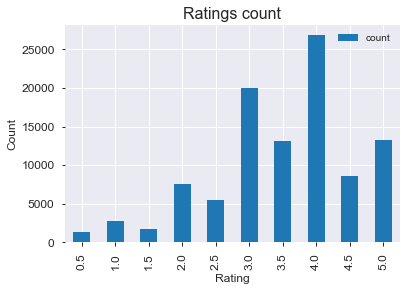

In [103]:
# Value counts of ratings
rat_val_count=ratings.groupBy('rating')\
                     .count()\
                     .orderBy('rating')\
                     .toPandas()\
                     .set_index('rating')

plt.figure()
rat_val_count.plot(kind='bar')
plt.title('Ratings count')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [74]:
# Select user, movie and rating 
# join movies and ratings
query="""
SELECT mov.movieId, rat.userId, rat.rating 
FROM movies as mov
INNER JOIN ratings AS rat
ON mov.movieId=rat.movieId
"""
df = spark.sql(query)
df.printSchema()

root
 |-- movieId: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)



In [75]:
df.show(1, vertical=True)

-RECORD 0------
 movieId | 1   
 userId  | 1   
 rating  | 4.0 
only showing top 1 row



In [76]:
# train/test split
(training_data, test_data) = df.randomSplit([0.8, 0.2],\
                                                 seed=1234)
# ALS Method
# rank: number of latent features
# regParam: regularisation parameter
# coldStartStrategy: avoid user all the ratings in the train set

als = ALS(userCol='userId',\
                itemCol='movieId',\
                ratingCol='rating',\
                rank=5,\
                maxIter=10,\
                regParam=0.05,\
                nonnegative=True,\
                coldStartStrategy='drop',\
                implicitPrefs=False)
als_model = als.fit(training_data)

# Evaluate the model by computing the RMSE on the test data
predictions = als_model.transform(test_data)
evaluator = RegressionEvaluator(metricName="rmse",\
                                labelCol="rating",\
                                predictionCol="prediction")
rmse = evaluator.evaluate(predictions)
print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.9074217988621893


In [77]:
# Generate top 10 movie recommendations for each user
userRecs = als_model.recommendForAllUsers(10)
# Generate top 10 user recommendations for each movie
movieRecs = als_model.recommendForAllItems(10)

In [78]:
userRecs.show()

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   471|[[2282, 5.3079705...|
|   463|[[2282, 5.6459827...|
|   496|[[159858, 6.47713...|
|   148|[[4256, 5.4957056...|
|   540|[[2282, 6.4041996...|
|   392|[[1468, 6.616458]...|
|   243|[[32892, 7.506631...|
|    31|[[4389, 7.942636]...|
|   516|[[26171, 6.187081...|
|   580|[[2282, 6.302004]...|
|   251|[[2282, 6.6287565...|
|   451|[[2282, 6.49038],...|
|    85|[[130634, 6.81259...|
|   137|[[183897, 5.14707...|
|    65|[[40, 5.4068484],...|
|   458|[[26171, 7.968506...|
|   481|[[72171, 6.262200...|
|    53|[[26171, 8.109869...|
|   255|[[5222, 8.669709]...|
|   588|[[2282, 5.5627084...|
+------+--------------------+
only showing top 20 rows



In [79]:
# TODO: to be completed
als_model.recommendForAllUsers(10).registerTempTable('ALS_userRecs_temp')
query="""
SELECT userId,
movieIds_and_ratings.movieId AS movieId
FROM ALS_userRecs_temp
LATERAL VIEW explode(recommendations) exploded_table 
AS movieIds_and_ratings
"""

exploded_recs = spark.sql(query)
exploded_recs.show()

+------+-------+
|userId|movieId|
+------+-------+
|   471|   2282|
|   471|     40|
|   471|   3379|
|   471|  33649|
|   471|   8235|
|   471|   3200|
|   471|  62293|
|   471| 171495|
|   471|   5034|
|   471| 159858|
|   463|   2282|
|   463|   5075|
|   463|  26133|
|   463|     40|
|   463|   8235|
|   463|   3379|
|   463|   3019|
|   463| 106100|
|   463| 143969|
|   463|  33649|
+------+-------+
only showing top 20 rows



In [ ]:
# TODO: complete the grid_search algorithm
"""
from pyspark.ml.tuning import ParamGridBuilder

# Add hyperparameters and their respective values to param_grid
param_grid = ParamGridBuilder() \
            .addGrid(als.rank, [5]) \
            .addGrid(als.maxIter, [10]) \
            .addGrid(als.regParam, [0.01]) \
            .build()

# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse",\
                                labelCol="rating",\
                                predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

# Build cross validation using CrossValidator
cv = CrossValidator(estimator=als,\
                    estimatorParamMaps=param_grid,\
                    evaluator=evaluator,\
                    numFolds=2)

#Fit cross validator to the 'train' dataset
model_grid_ALS = cv.fit(training_data)

#Extract best model from the cv model above
best_model = model_grid_ALS.bestModel

# Print best_model
print(type(best_model))

# Complete the code below to extract the ALS model parameters
print("**Best Model**")

# Print "Rank"
print("  Rank:", best_model.getRank())

# Print "MaxIter"
print("  MaxIter:", best_model.getMaxIter())

# Print "RegParam"
print("  RegParam:", best_model.getRegParam())
"""

<class 'pyspark.ml.recommendation.ALSModel'>
**Best Model**


AttributeError: 'ALSModel' object has no attribute 'getRank'